# Notebook to load a trained model and verify it on some images

In [2]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
from data_process import *

# U-Net

In [31]:
#Architect of U_net
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias = False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1,bias = False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(self, in_channels=3, out_channels=10, features = [64, 128, 256, 512]):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        #Down part of U_net
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        #Up
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                    )# 28*1024 -> 56 * 512
            )
            self.ups.append(DoubleConv(feature*2, feature))
        #bottle
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)  #1024
        #final FF
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)

        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            #checking
            if x.shape != skip_connection.shape:
                x = TF.resize(x, size= skip_connection.shape[2:])
            concat_skip = torch.cat((skip_connection, x), dim = 1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

# ResNeSt

In [4]:
class rSoftmax(nn.Module):
    """rSoftmax module, as per the paper"""
    def __init__(self, radix, cardinality):
        super().__init__()
        self.radix = radix
        self.cardinality = cardinality
    
    def forward(self, x):
        batch = x.size(0)
        if self.radix > 1:
            x = x.view(batch, self.cardinality, self.radix, -1).transpose(1,2)
            x = x.softmax(dim=1)
            x = x.reshape(batch, -1)
        else:
            x = torch.sigmoid(x)
        
        return x

# Blocks to have ResNet become ResNeSt
class SplitAttention(nn.Module):
    def __init__(self, in_c, out_c, kernel_size, radix=2, cardinality=1, bias=True, stride=1, padding=0):
        """Initialises a SplitAttention block, as part of the ResNeSt block

        Args:
            in_c (int): input channels
            radix (int): number of splits within a cardinal group, denoted r
            cardinality (int): number of feature map groups, denoted k
        """
        super().__init__()
        self.radix = radix
        self.cardinality = cardinality
        self.channels = out_c
        self.conv = nn.Conv2d(in_c, out_c*radix, kernel_size=kernel_size, groups=cardinality*radix, 
                              bias=bias, padding=padding, stride=stride)
        self.bn1 = nn.BatchNorm2d(out_c*radix)
        self.bn2 = nn.BatchNorm2d(out_c*radix)
        self.fc1 = nn.Conv2d(out_c, out_c*radix, kernel_size=1, groups=cardinality)
        self.fc2 = nn.Conv2d(out_c*radix, out_c*radix, kernel_size=1, groups=cardinality)
        self.relu = nn.ReLU(inplace=True)
        self.rsoftmax = rSoftmax(radix, cardinality)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        batch, rchannel = x.shape[:2]
        if self.radix > 1:
            splited = torch.split(x, int(rchannel//self.radix), dim=1)
            gap = sum(splited)
        else:
            gap = x
        gap = nn.functional.adaptive_avg_pool2d(gap, 1)
        gap = self.fc1(gap)
        gap = self.bn2(gap)
        gap = self.relu(gap)
        
        atten = self.fc2(gap)
        atten = self.rsoftmax(atten).view(batch, -1, 1, 1)
        
        if self.radix > 1:
            attens = torch.split(atten, int(rchannel//self.radix), dim=1)
            out = sum([att*split for (att, split) in zip(attens, splited)])
        else:
            out = atten * x
        
        return out.contiguous()

In [5]:
class Block(nn.Module):     # ResNeSt block (bottleneck)
    expansion = 4
    def __init__(self, in_c, out_c, radix=2, cardinality=1, downsample=None, stride=1):
        """Initialises the ResNeSt block

        Args:
            in_c (int): input channels
            out_c (int): output channels
            radix (int): number of splits within a cardinal group, denoted R
            cardinality (int): number of cardinal groups, denoted K
            downsample (_type_, optional): _description_. Defaults to None.
            stride (int, optional): stride. Defaults to 1.
        """
        super().__init__()
        group_width = int(out_c * cardinality)
        self.conv1 = nn.Conv2d(in_c, group_width, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(group_width)
        self.radix = radix
        if radix >= 1:  
            self.conv2 = SplitAttention(group_width, group_width, kernel_size=3, radix=radix, 
                                        cardinality=cardinality, bias=False, padding=1, stride=stride)
        else:
            self.conv2 = nn.Conv2d(group_width, group_width, kernel_size=3, 
                                   cardinality=cardinality, bias=False, padding=1, stride=stride)
            self.bn2 = nn.BatchNorm2d(group_width)

        self.conv3 = nn.Conv2d(group_width, out_c*self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_c*self.expansion)

        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        

    def forward(self, x):
        residual = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        # x = self.bn2(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        
        if self.downsample is not None:
            residual = self.downsample(residual)

        x += residual
        x = self.relu(x)
        
        return x
        
        
class ResNeSt(nn.Module):
    def __init__(self, block, layers, img_c, n_classes):
        """Initialises the ResNeSt model

        Args:
            block (nn.Module): The ResNeSt block
            layers (list): holding the number of blocks in each layer
            img_c (int): input channels
            n_classes (int): output classes 
        """
        self.cardinality = 1
        self.group_width = 64
        
        super().__init__()
        # Initial layer, same as for ResNet this is NOT a ResNeSt layer
        self.conv1 = nn.Conv2d(img_c, self.group_width, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.group_width)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # ResNeSt layers
        self.layer1 = self._make_layer(block, layers[0], out_c=64, radix=2, cardinality=1, stride=1)
        self.layer2 = self._make_layer(block, layers[1], out_c=128, radix=2, cardinality=1, stride=2)
        self.layer3 = self._make_layer(block, layers[2], out_c=256, radix=2, cardinality=1, stride=2)
        self.layer4 = self._make_layer(block, layers[3], out_c=512, radix=2, cardinality=1, stride=2)
        
        self.dropout = nn.Dropout(p=0.2)    # as per paper
        self.final_conv = nn.Conv2d(512*block.expansion, n_classes, kernel_size=1)
        self.upsample = nn.Upsample((256, 256), mode='bilinear', align_corners=True)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels # He initialisation
                m.weight.data.normal_(0, np.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)  # Initialise BN as per paper
                m.bias.data.zero_()
        
    def _make_layer(self, block, n_blocks, out_c, radix, cardinality, stride):
        """Internal function to create the ResNeSt layers

        Args:
            block (Block): convolutional block as per the ResNet architecture
            n_res_blocks (int): number of residual blocks, number of times blocks are used
            out_c (int): number of channels when done with this layer
            radix (int): number of splits within a cardinal group, denoted R
            cardinality (int): number of cardinal groups, denoted K
            stride (int): 1 or 2 depending on the layer
        """
        downsample = None
        
        if stride != 1 or self.group_width != out_c * block.expansion:
            down_layers = []
            down_layers.append(nn.Conv2d(self.group_width, out_c * block.expansion, kernel_size=1, 
                                         stride=stride, bias=False))
            down_layers.append(nn.BatchNorm2d(out_c * block.expansion))
            downsample = nn.Sequential(*down_layers)
            
        layers = []
        layers.append(block(self.group_width, out_c, radix, cardinality, downsample, stride))
        self.group_width = out_c * block.expansion
        for _ in range(1, n_blocks):
            layers.append(block(self.group_width, out_c, radix, cardinality))
            
        return nn.Sequential(*layers)
    
    def forward(self, x):

        x = self.conv1(x)   # initial layer
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)    

        x = self.layer1(x) # ResNeSt layers
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.dropout(x)

        x = self.final_conv(x)
        x = self.upsample(x)
        
        return x
    

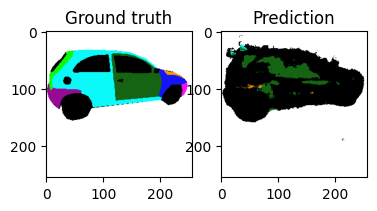

In [41]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torch.load("../trained_models/unet_model-final-1strun.pt", map_location=device)
model.eval()
if __name__ =='__main__':
    random_car = "../data/random_car.jpg"
    path_to_seg_img = "../data/test_data/array/image_09.npy"
    path_to_no_seg_img = "../data/test_data/image/image_9.png"
    reference = np.load(path_to_seg_img)[:,:,:3]
    ref_mask = np.load(path_to_seg_img)[:,:,3]
    imgA = imread(path_to_no_seg_img)
    imgA = resize_2_256(imgA)

    transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                         std=[0.229, 0.224, 0.225])])
    imgA = transform(imgA)
    imgA = imgA.to(device)
    imgA = imgA.unsqueeze(0)
    output = model(imgA)
    output = torch.sigmoid(output)

    output_np = output.cpu().detach().numpy().copy()  # output_np.shape = (1, 10, 256, 256)
    #print(output_np.shape)   #(1, 10, 256, 256)
    output_np = (np.argmax(output_np, axis=1) * 10).astype(np.uint8)
    # print(output_np.shape)  #(1,256, 256)
    #print(output_np[0,...])
    plt.subplot(1, 3, 1)
    plt.title("Ground truth")
    plt.imshow(label_2_colour(ref_mask))
    plt.subplot(1, 3, 2)
    plt.title("Picture")
    plt.imshow(reference)
    plt.subplot(1, 3, 2)
    plt.title("Prediction")
    plt.imshow(label_2_colour(output_np[0, ...]))
